# Gamma Ray Reconstruction for the AdEPT Mission
### Spencer R. Deevy - deevys@mcmaster.ca

# Acknowledgements

##### Dr. Andrei Hanu - andrei.hanu@brucepower.com
A large portion of the code used in this notebook is derived from previous work on AdEPT code, written by Dr. Andrei Hanu.  
Dr. Hanu's code can be found alongside this notebook, and was last listed as "AdEPT_G4_Cellular_Automata_KDTree.ipynb"

##### Richard Garnett - garnetri@mcmaster.ca
Images used in this notebook were created by Richard Garnett.  
Future developers can obtain access to this simulation by contacting Richard Garnett through his Github account (garnetri)

# Import required libraries

In [1]:
# Matplotlib and other plotting libraries
from matplotlib import collections as mc
from matplotlib import pyplot as plt

import cv2                                              # OpenCV
import numpy as np                                      # Numpy
from palettable.colorbrewer.sequential import Greys_9_r # Colour map
from scipy.spatial import cKDTree                       # KD Tree

# Load Simulation Images from Geant4

In [2]:
# Load the Geant4 simulation images (XZ and YZ projections)
# Images needed to be flipped due to read-in method
image_raw_XZ = np.flipud(cv2.imread('Data/Gamma Rays/Gamma_01_XZ.png', cv2.IMREAD_GRAYSCALE))
image_raw_YZ = np.flipud(cv2.imread('Data/Gamma Rays/Gamma_01_YZ.png', cv2.IMREAD_GRAYSCALE))

# Get shape of images
rows_XZ, columns_XZ = image_raw_XZ.shape
rows_YZ, columns_YZ = image_raw_YZ.shape

# Find all of the detector hits (Pixel value > 0)
hits_XZ = np.column_stack(np.where(np.transpose(image_raw_XZ) > 0))
hits_YZ = np.column_stack(np.where(np.transpose(image_raw_YZ) > 0))

# Sort detector hits (First by Z (Column 1), then by X/Y (Column 0))
hits_XZ = hits_XZ[np.lexsort((hits_XZ[:, 0], hits_XZ[:, 1]))]
hits_YZ = hits_YZ[np.lexsort((hits_YZ[:, 0], hits_YZ[:, 1]))]

# Plot Raw Detector Images

Saving raw image of detector hits to: Detector_Hits_XZYZ.pdf


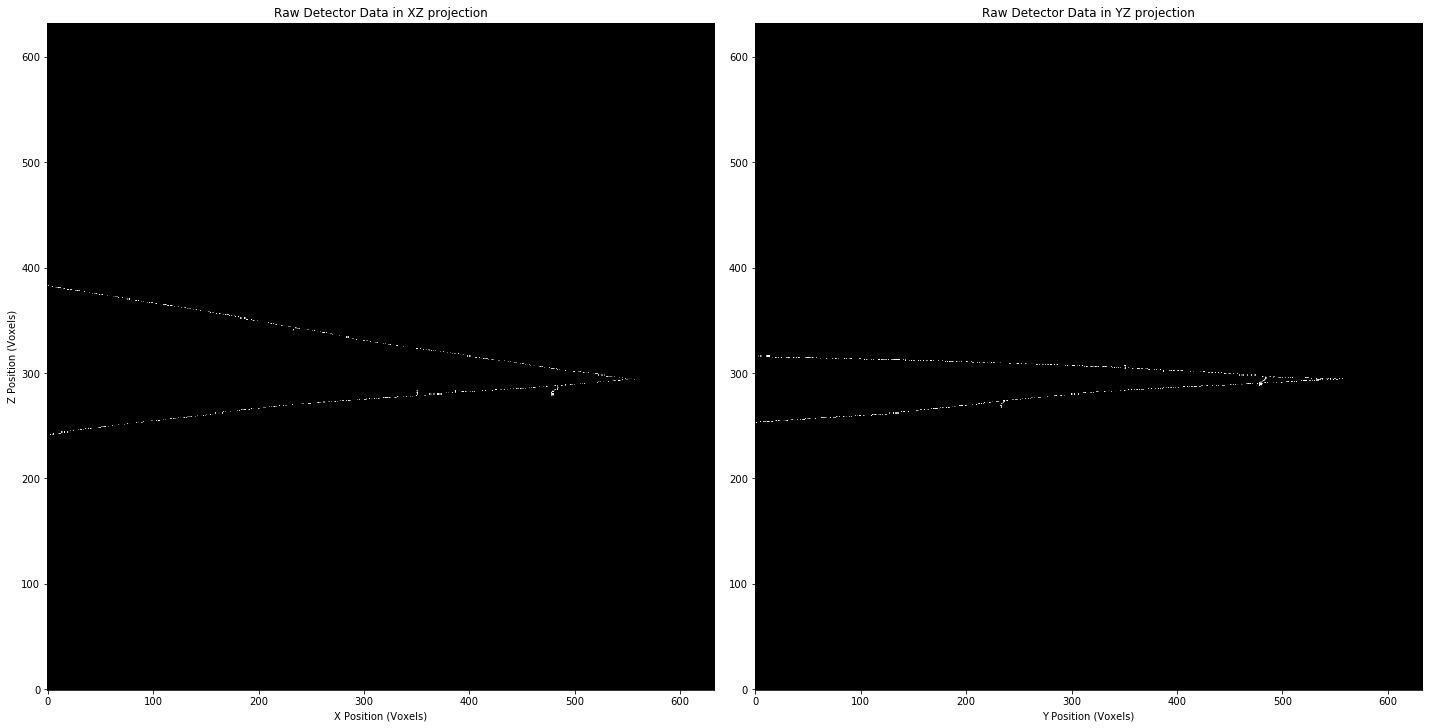

In [3]:
figure_raw, (ax_raw_XZ, ax_raw_YZ) = plt.subplots(1, 2, figsize=(20, 15))

cmap = Greys_9_r.mpl_colormap

# Plot the raw images; Plots neededed to be enhanced to produce visible plots
ax_raw_XZ.imshow(image_raw_XZ * 10, origin = 'lower', cmap = cmap, interpolation = 'nearest')
ax_raw_YZ.imshow(image_raw_YZ * 10, origin = 'lower', cmap = cmap, interpolation = 'nearest')

# No grid
ax_raw_XZ.grid(False)
ax_raw_YZ.grid(False)

# Set labels
ax_raw_XZ.set_xlabel('X Position (Voxels)')
ax_raw_YZ.set_xlabel('Y Position (Voxels)')
ax_raw_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_raw_XZ.set_title('Raw Detector Data in XZ projection')
ax_raw_YZ.set_title('Raw Detector Data in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_raw_XZYZ ='Detector_Hits_XZYZ.pdf'
plt.savefig(file_raw_XZYZ)
print('Saving raw image of detector hits to: ' + file_raw_XZYZ)

plt.show(figure_raw)

# Plot Detector Hits

Saving image of detector hits to: Detector_Hits_XZYZ.pdf


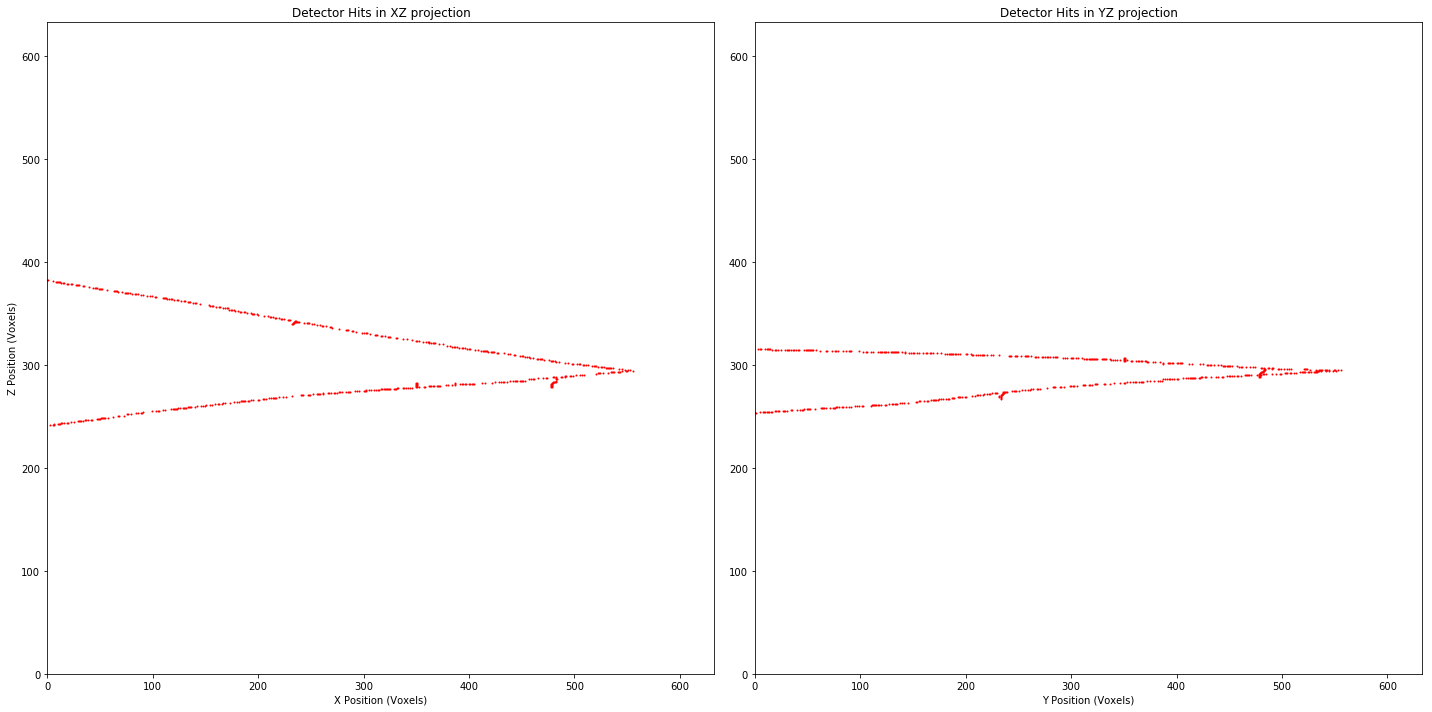

In [4]:
figure_hits, (ax_hits_XZ, ax_hits_YZ) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the detector hits
ax_hits_XZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=2, color='red') 
ax_hits_YZ.plot(hits_YZ[:,0], hits_YZ[:,1], '.', ms=2, color='red')

# Set axis limits
ax_hits_XZ.set_xlim(0, rows_XZ)
ax_hits_XZ.set_ylim(0, columns_XZ)
ax_hits_YZ.set_xlim(0, rows_YZ)
ax_hits_YZ.set_ylim(0, columns_YZ)

# Set labels
ax_hits_XZ.set_xlabel('X Position (Voxels)')
ax_hits_YZ.set_xlabel('Y Position (Voxels)')
ax_hits_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_hits_XZ.set_title('Detector Hits in XZ projection')
ax_hits_YZ.set_title('Detector Hits in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_hits_XZYZ ='Detector_Hits_XZYZ.pdf'
plt.savefig(file_hits_XZYZ)
print('Saving image of detector hits to: ' + file_hits_XZYZ)

plt.show(figure_hits)

# Build KD Tree of Detector Hits

In [5]:
# Insert XZ hits and YZ hits into repective KD trees
tree_XZ = cKDTree(hits_XZ, leafsize=15)
tree_YZ = cKDTree(hits_YZ, leafsize=15)

# Initial Track Segment Generation

In [6]:
# Function to calculate the angle between a track segment and the Z-axis
# Return angle and magnitude
#
# Expects a numpy ndarrays [proj_i z_i proj_f z_f] where:
# proj_i - starting x/y coordinate
# z_i    - starting z coordinate
# proj_f - final x/y coordinate
# z_f    - final z coordinate

def calcSegmentAngleLength(segA):
    # Create vectors
    vA = [(segA[2] - segA[0]), (segA[3] - segA[1])]
    vZ = [(0), (1)]
    vX = [(1), (0)]
    
    # Calculate the dot product between the input vector and Z/X axis
    dotvAZ = np.dot(vA, vZ)
    dotvAX = np.dot(vA, vX)
    
    # Calculate the magnitude of the input vector
    magA = np.dot(vA, vA)**0.5
    
    # Return the angle in degrees
    if dotvAX >= 0:
        return np.degrees(np.arccos(dotvAZ/magA)), magA
    else:
        return -1*np.degrees(np.arccos(dotvAZ/magA)), magA

In [61]:
def findInitialTrackSegments(hits_proj, tree_proj, proj_type):

    # Minimum, maximum search radii
    radius_minimum = 15
    radius_maximum = 20
    radius_step = 1

    # Acceptance angle for overlaping tracks (+/- degrees)
    theta_accept = 15

    # Initialize a list which stores the track segments
    # trackSeg[0:1] = X,Z pair for Hit 1
    # trackSeg[2:3] = X,Z pair for Hit 2
    track_segments = []

    # Loop through all of the hits and find their nearest neighbours starting from the smallest radius to the largest
    # The principal axis is Z

    # Move in the forward direction
    for (proj, z) in hits_proj:
        
        # Start with the smallest search radius
        search_radius = radius_minimum

        # Initialize a list of potential track segments from the current hit
        potential_track_segments = []

        # Find all of the nearest neighbours of the current 
        # Search until you find something or the search radius exceeds the maximum allowed limit
        while search_radius < radius_maximum:

            # Find all neighbouring hits within distance r of the current hit
            hits_near = hits_proj[tree_proj.query_ball_point([proj, z], search_radius)]

            # Filter hits in the forward direction
            hits_forward = hits_near[hits_near[:, 1] >= z]

            # Are there any hits forward of the current search hit?
            if len(hits_forward) > 0: 
                # Loop through the potential list of forward neighbours
                for (proj_NN, z_NN) in hits_forward:
                    # Skip the current search hit since it will also be found in the tree
                    if (proj_NN, z_NN) != (proj, z):
                        # We need to be careful for hits on the same Z axis such that the potential track segments
                        # are connected from lowest X coordinate to the highest 
                        # This will help to filter out overlaping track segments
                        if (z_NN == z) and (proj_NN > proj):
                            # Same Z
                            # Connect low X to high X
                            potential_track_segments.append(np.array([proj, z, proj_NN, z_NN]))
                        elif (z_NN > z):
                            potential_track_segments.append(np.array([proj, z, proj_NN, z_NN]))

                # Did we make any potential track segments
                if len(potential_track_segments) > 0:
                    # Yes, but they need to be filtered for duplicate angles
                    # If multiple tracks have approximately the same angle, keep the shortest one
                    for i in range(len(potential_track_segments)):
                        # Assume the track segment is a good candidate until otherwise
                        goodSegment = True
                        for j in range(len(potential_track_segments)):
                            if i != j:
                                # Compare angles & lengths
                                segi, leni = calcSegmentAngleLength(potential_track_segments[i])
                                segj, lenj = calcSegmentAngleLength(potential_track_segments[j])
                                if np.absolute(segi - segj) < theta_accept:
                                    # These segments are too close in angle
                                    if leni > lenj:
                                        # The current search segment is not the shortest and therefore not a valid segment
                                        goodSegment = False
                                        break

                        # If this segment is still good, append to list
                        if goodSegment == True:
                            track_segments.append(potential_track_segments[i])

                    # We've made a good track segment. Let's stop the search here!
                    search_radius = radius_maximum 
                else:
                    # Not yet! Increase the search radius
                    search_radius += radius_step
            else:
                # Not yet! Increase the search radius
                search_radius += radius_step

    # Stack the list vertically into a numpy array
    track_segments = np.vstack(track_segments)

    # Filter for unique track segments
    track_segments= np.vstack({tuple(row) for row in track_segments})

    # Sort the track segments
    # First by column 1 in ascending order 
    # Then by column 0 in ascending order
    # Then by column 3 in ascending order
    # Then by column 2 in ascending order
    track_segments = track_segments[np.lexsort((track_segments[:, 2],track_segments[:, 3],track_segments[:, 0],track_segments[:, 1]))]

    # Output some useful information
    print('Initial ' + proj_type + 'Z track segments:', len(track_segments))

    return track_segments

In [62]:
# Find XZ and YZ initial track segments
init_segs_XZ = findInitialTrackSegments(hits_XZ, tree_XZ, 'X')
init_segs_YZ = findInitialTrackSegments(hits_YZ, tree_YZ, 'Y')

Initial XZ track segments: 979
Initial YZ track segments: 1054


# Plot Initial Track Segments

Saving image of detector hits to: Init_Track_Segs_XZYZ.pdf


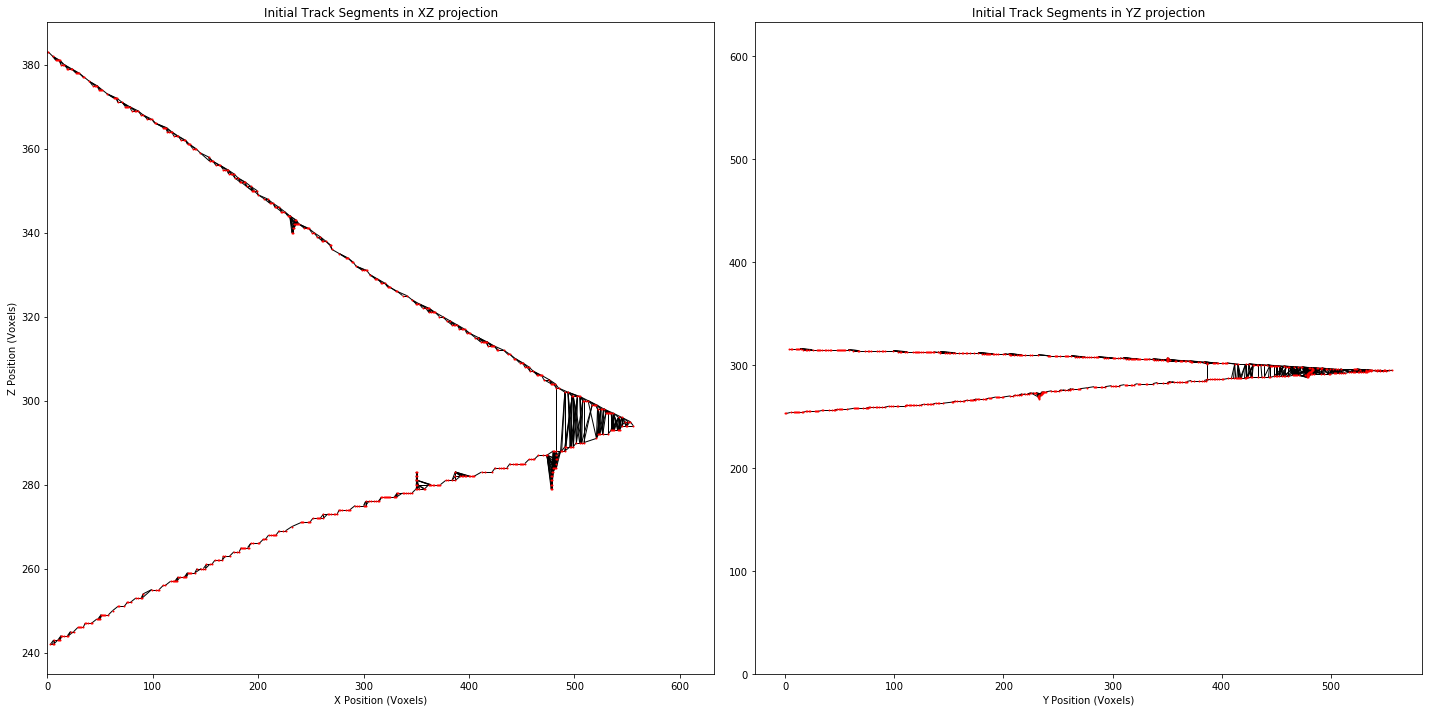

In [63]:
figure_init_segs, (ax_init_segs_XZ, ax_init_segs_YZ) = plt.subplots(1, 2, figsize=(20, 10))

# Use LineCollection to efficiently plot the many track segments
lcx = mc.LineCollection(zip(zip(init_segs_XZ[:, 0], init_segs_XZ[:, 1]),
                            zip(init_segs_XZ[:, 2], init_segs_XZ[:, 3])),
                        linewidths=1, color='k')
lcy = mc.LineCollection(zip(zip(init_segs_YZ[:, 0], init_segs_YZ[:, 1]),
                            zip(init_segs_YZ[:, 2], init_segs_YZ[:, 3])),
                        linewidths=1, color='k')

# Add line collections to subplots
ax_init_segs_XZ.add_collection(lcx)
ax_init_segs_YZ.add_collection(lcy)

# Plot the detector hits
ax_init_segs_XZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=2, color='red') 
ax_init_segs_YZ.plot(hits_YZ[:,0], hits_YZ[:,1], '.', ms=2, color='red')

# Set axis limits
ax_init_segs_XZ.set_xlim(0, rows_XZ)
ax_init_segs_YZ.set_ylim(0, columns_XZ)
ax_init_segs_XZ.set_xlim(0, rows_YZ)
ax_init_segs_YZ.set_ylim(0, columns_YZ)

# Set labels
ax_init_segs_XZ.set_xlabel('X Position (Voxels)')
ax_init_segs_YZ.set_xlabel('Y Position (Voxels)')
ax_init_segs_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_init_segs_XZ.set_title('Initial Track Segments in XZ projection')
ax_init_segs_YZ.set_title('Initial Track Segments in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_init_segs_XZYZ ='Init_Track_Segs_XZYZ.pdf'
plt.savefig(file_init_segs_XZYZ)
print('Saving image of detector hits to: ' + file_init_segs_XZYZ)

plt.show(figure_init_segs)

# Calculating Angle Between Neighbouring Track Segments

In [64]:
# Function to calculate the angle between two neighbouring track segments
#
# Expects two numpy ndarrays [proj_i z_i proj_f z_f] where:
# proj_i - starting x/y coordinate
# z_i    - starting z coordinate
# proj_f - final x/y coordinate
# z_f    - final z coordinate

def calcTrackSegmentAngle(segA, segB):
    # Create vectors
    vA = [(segA[2] - segA[0]), (segA[3] - segA[1])]
    vB = [(segB[2] - segB[0]), (segB[3] - segB[1])]
    
    # Calculate the dot product between the vectorss
    dotvAvB = np.dot(vA, vB)
    
    # Calculate the magnitude of each vector
    magA = np.dot(vA, vA)**0.5
    magB = np.dot(vB, vB)**0.5
    
    # Return the angle in degrees
    return np.degrees(np.arccos(dotvAvB/magA/magB))

# Forward Cellular Automaton

In [66]:
def filterTrackSegments(track_segs):
    # Threshold angle between neighbouring track segments that share a common middle point
    # In degrees
    thetaMax = 45

    # Number of track segments
    numTrackSeg = track_segs.shape[0]

    # State of each track segment
    stateCurrent = np.zeros(numTrackSeg, dtype=np.int64)

    # Run the cellular automaton
    while True:
        # Initialize the update state array
        stateUpdate = np.zeros(numTrackSeg, dtype=np.int64)

        # Loop through all the track segments
        for i in range(0,numTrackSeg):
            for j in range(i+1,numTrackSeg):
                # Find neighbouring track segments in the forward direction and with the same state
                if np.equal(track_segs[i,2:4], track_segs[j,0:2]).all() and (stateCurrent[i] == stateCurrent[j]):
                    # Is the angle between track segments below our threshold angle?
                    segAngle = calcTrackSegmentAngle(track_segs[i], track_segs[j])
                    if  segAngle < thetaMax:
                        # The angle between neighbouring track segments is within the threshold angle
                        # Update the state for this neighbours
                        stateUpdate[j] = 1

        if np.sum(stateUpdate) > 0:
            # Update the status of all the track segments
            stateCurrent += stateUpdate
        else:
            break
    return stateCurrent

# Plot Track Segments After Forward Cellular Automaton Filter

In [69]:
# Filter track segments that still have 0 state
state_XZ = filterTrackSegments(init_segs_XZ)
#state_YZ = filterTrackSegments(init_segs_YZ)

track_segs_CA_NULL_XZ = init_segs_XZ[np.where(state_XZ == 0)]
track_segs_CA_GOOD_XZ = init_segs_XZ[np.where(state_XZ > 0)]
#track_segs_CA_NULL_YZ = init_segs_YZ[np.where(state_YZ == 0)]
#track_segs_CA_GOOD_YZ = init_segs_YZ[np.where(state_YZ > 0)]

#trackSegCA_0 = trackSeg[np.where(stateCurrent==0)]
trackSegCA_NOT_0 = track_segs_CA_GOOD_XZ

##### Plot initial track segments for XZ projection
figTrackSegCAXZ, (axTrackHitsXZ,axTrackSegCAXZ) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5))

lc_NOT_0 = mc.LineCollection(zip(zip(trackSegCA_NOT_0[:,0],trackSegCA_NOT_0[:,1]),zip(trackSegCA_NOT_0[:,2],trackSegCA_NOT_0[:,3])),
                             cmap=cmap,
                             norm=plt.Normalize(state_XZ[np.where(state_XZ>0)].min(), state_XZ[np.where(state_XZ>0)].max()))
lc_NOT_0.set_array(state_XZ[np.where(state_XZ>0)])
lc_NOT_0.set_linewidth(0.75)
axTrackSegCAXZ.add_collection(lc_NOT_0)

# Load the image data from CV2 into matplotlib
axTrackSegCAXZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=3, color='red') 
axTrackHitsXZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=3, color='red')

# Axis Properties
axTrackHitsXZ.set_xlim(0,211)
axTrackHitsXZ.set_ylim(0,211)
axTrackSegCAXZ.set_xlim(0,211)
axTrackSegCAXZ.set_ylim(0,211)

axTrackHitsXZ.set_xlabel('X axis')
axTrackSegCAXZ.set_xlabel('X axis')
axTrackHitsXZ.set_ylabel('Z axis')

plt.setp(axTrackSegCAXZ.get_yticklabels(), visible=False)

# Colorbar, make sure to specify tick locations to match desired ticklabels
cbar = figTrackSegCAXZ.colorbar(lc_NOT_0)

# Figure Properties
axTrackHitsXZ.set_title('Initial Track Segments in XZ projection')
axTrackSegCAXZ.set_title('Cellular Automaton Track Segments in XZ Projection')
figTrackSegCAXZ.subplots_adjust(wspace=0.01)

# Save the figure 
fileTrackSegCAXZ ='Track_Segments_Forward_CA_XZ.pdf'
plt.savefig(fileTrackSegCAXZ)
print('Saving plot of initial track segments for the XZ projection to: ' + fileTrackSegCAXZ)

# Show the image
plt.show(figTrackSegCAXZ)


C:\Users\Deevy\Programs_x64\envs\AdEPT36\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos


KeyboardInterrupt: 